# Emerging Topics final code - Coronavirus

This code was created from Martha and Sean's emerging topic code and was used to create the hottest/coldest topics static graphics for the full, pandemics, and coronavirus corpora.

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

import seaborn as sns

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2019.10-py3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data Ingestion

In [2]:
# full corpus
#df = pd.read_pickle("../../data/final/final_dataset_7-20.pkl")

# pandemic corpus
#df = pd.read_pickle("/home/kjl5t/dspg20RnD/data/final/dashboard_data/pandemic_corpus.pkl")
#df.reset_index(inplace=True)

# coronavirus corpus
df = pd.read_pickle("/home/kjl5t/dspg20RnD/data/final/dashboard_data/corona_corpus.pkl")
df.reset_index(inplace=True)

In [3]:
df.head()

,level_0,index,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,...,working_abstract,Start_Char,nchar,LAST_CHAR,lemma_abstract,clean_lemmas,stopwds_removed,n_grams_added,final_tokens,final_frqwds_removed
0,413,413,287859,701145,As scientists with a keen interest in non-Hodg...,2009,Adult; Alleles; Biological Assay; blastocyst; ...,BIOMEDICAL (BASIC),HHS,NIH,...,As scientists with a keen interest in non-Hodg...,A,2071,I,"[scientist, keen, interest, non-hodgkin, lymph...","[scientist, keen, interest, non-hodgkin, lymph...","[scientist, keen, interest, non-hodgkin, lymph...","[scientist, keen_interest, non-hodgkin_lymphom...","[scientist, keen_interest, non_hodgkin_lymphom...","[scientist, keen_interest, non_hodgkin_lymphom..."
1,1038,1038,370882,586081,Objective(s): Develop environmentally acceptab...,2010,Area; Asians; Behavior; Biocontrols; Biology; ...,"DETECTION CONTROL, AND AREA-WIDE MANAGEMENT OF...",USDA,ARS,...,Develop environmentally acceptable and economi...,D,1068,0,"[develop, environmentally, acceptable, economi...","[develop, environmentally, acceptable, economi...","[develop, environmentally, acceptable, economi...","[develop, environmentally, acceptable, economi...","[develop, environmentally, acceptable, economi...","[environmentally, acceptable, economically_fea..."
2,2555,2555,21329,153888,DESCRIPTION (provided by applicant): Human cor...,2008,Acute; Age-Years; Antigens; Archives; base; Bi...,EPIDEMIOLOGY AND CLINICAL FEATURES OF HUMAN CO...,HHS,NIH,...,Human coronaviruses (HCoV) were initially iden...,H,2066,y,"[human, coronaviruse, HCoV, initially, identif...","[human, coronaviruse, hcov, initially, identif...","[human, coronaviruse, hcov, initially, identif...","[human, coronaviruse_hcov, initially, identify...","[human, coronaviruse_hcov, initially, identify...","[human, coronaviruse_hcov, initially, acute, r..."
3,2928,2928,23454,154633,DESCRIPTION (provided by applicant): The pro-a...,2008,1-Phosphatidylinositol 3-Kinase; Address; Alph...,NOVEL MECHANISMS OF PTEN GENE REGULATION,HHS,NIH,...,The pro-apoptotic tumor suppressor gene PTEN (...,T,2141,N,"[pro-apoptotic, tumor, suppressor, gene, pten,...","[pro-apoptotic, tumor, suppressor, gene, pten,...","[pro-apoptotic, tumor, suppressor, gene, pten,...","[pro-apoptotic, tumor, suppressor, gene, pten,...","[pro_apoptotic, tumor, suppressor, gene, pten,...","[pro_apoptotic, tumor, suppressor, gene, pten,..."
4,3217,3217,21995,154182,DESCRIPTION (provided by applicant): Category ...,2008,Agar; assay development; base; Biochemical; Bi...,YEAST-BASED HIGH-THROUGHPUT ASSAYS FOR PROTEAS...,HHS,NIH,...,"Category A, B & C priority pathogens include b...",C,2147,n,"[category, a, b, c, priority, pathogen, includ...","[category, a, b, c, priority, pathogen, includ...","[category, b, c, priority, pathogen, biologica...","[category, b, c, priority, pathogen, biologica...","[category, priority, pathogen, biological, age...","[category, priority, pathogen, biological, age..."


In [4]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []
docs = df["final_frqwds_removed"]

for abstract in docs:
    text.append(" ".join(abstract))

### Functions needed for all models

In [5]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(topic_term_mat, vectorizer, top_n=10):
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [6]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

## NMF
- Optimal Model: full dataset, 75 topics, random_state = 14
- Pandemic Model: pandemic dataset, 30, random_state = 1
- Coronavirus Model: coronavirus dataset, 30, random_state = 1

In [7]:
# use for full dataset
#tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=20, lowercase=False, max_features=int(len(docs)/2))
#tf_idf = tfidf_vectorizer.fit_transform(text)

# use for pandemic or coronavirus dataset
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False)
tf_idf = tfidf_vectorizer.fit_transform(text)


In [8]:
# create model

num_topics = 30 

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 1)
doc_topic = nmf_model.fit_transform(tf_idf)
t2 = time.time()
print(f"  Model time: {t2-t1}")

topic_term = nmf_model.components_

  Model time: 0.9695961475372314


In [9]:
#print_topics(nmf_model, tfidf_vectorizer, 10)

### Emerging Topics

In [9]:
# Extract Year from PROJECT_START_DATE

#On our graphs, we want to be able to show year. Therefore, this getYear function gets the year from different date formats from Project Start Year/End Year

#START

def getYear(a):   
    a = str(a)
    if a.find("/"):
        splitdate = a.split("/")
        if len(splitdate) == 3:
            a = splitdate[2]
        else:
            a = splitdate[0]
    year = str(a)
    return year

df['START_YEAR'] = df['PROJECT_START_DATE'].apply(getYear)

In [10]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["START_YEAR"] = df["START_YEAR"]


In [11]:
topic_frame_se = topic_frame.groupby("START_YEAR").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "START_YEAR")
topic_frame_se["START_YEAR"] = topic_frame_se["START_YEAR"].astype(int)

topic_wts_se_2010_2019 = topic_frame_se[topic_frame_se["START_YEAR"] > 2009] 
topic_wts_se_2010_2019 = topic_wts_se_2010_2019[topic_wts_se_2010_2019["START_YEAR"] < 2020]

In [12]:
topic_frame = topic_frame.groupby("START_YEAR").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "START_YEAR")
topic_frame["START_YEAR"] = topic_frame["START_YEAR"].astype(int)

In [13]:
topic_frame.head()

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
0,1975,0.015666,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.010279,...,0.000318,0.000000,0.115231,0.000000,0.000000,0.006696,0.000000,0.003177,0.009555,0.000000
1,1977,0.091014,0.000000,0.000000,0.000000,0.0,0.000000,0.000883,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.003131,0.000000,0.006767,0.001466,0.000761,0.003395,0.001123
2,1979,0.096988,0.001068,0.001034,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000643,0.000000,0.000000,0.000000,0.000000
3,1980,0.004664,0.007756,0.010586,0.031564,0.0,0.000000,0.011239,0.114404,0.004281,...,0.000000,0.002096,0.000000,0.020655,0.034093,0.000000,0.006696,0.001449,0.022376,0.004341
4,1981,0.000000,0.000335,0.201549,0.015816,0.0,0.000335,0.000000,0.009085,0.001884,...,0.000000,0.000000,0.004748,0.001659,0.031184,0.008958,0.003062,0.010022,0.000317,0.001017


In [14]:
# filter topic_frame for years 2010 - 2019

topic_wts_2010_2019 = topic_frame[topic_frame["START_YEAR"] > 2009] 
topic_wts_2010_2019 = topic_wts_2010_2019[topic_wts_2010_2019["START_YEAR"] < 2020] 

In [15]:
topic_wts_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
25,2010,0.006288,0.018283,0.011346,0.045297,0.005492,0.008479,0.008943,0.012667,0.009179,...,0.005782,0.005079,0.023621,0.005340,0.011538,0.003752,0.006606,0.016260,0.016424,0.011765
26,2011,0.002494,0.041893,0.011518,0.033525,0.003599,0.010725,0.009964,0.027206,0.011010,...,0.003562,0.005743,0.026042,0.003640,0.013209,0.007172,0.002580,0.010814,0.015662,0.012068
27,2012,0.003481,0.034084,0.018928,0.013790,0.034789,0.012982,0.014327,0.016453,0.010894,...,0.006904,0.007934,0.004893,0.002012,0.019317,0.007199,0.012359,0.011111,0.020944,0.015843
28,2013,0.007840,0.016919,0.013485,0.015581,0.027846,0.009307,0.012170,0.015580,0.008485,...,0.020685,0.004768,0.003316,0.001582,0.021889,0.005953,0.011429,0.003271,0.020782,0.002169
29,2014,0.003911,0.024314,0.010685,0.002749,0.029548,0.008842,0.010250,0.011713,0.010973,...,0.011531,0.014962,0.015154,0.006312,0.003096,0.008185,0.015390,0.002830,0.009871,0.001806
30,2015,0.004788,0.023261,0.013444,0.006127,0.029515,0.010923,0.008991,0.010120,0.009513,...,0.010796,0.015603,0.005746,0.015246,0.005617,0.012030,0.011133,0.003201,0.006655,0.001836
31,2016,0.004391,0.023485,0.019110,0.014952,0.036928,0.007909,0.007506,0.005292,0.010725,...,0.008039,0.013945,0.009172,0.008635,0.006376,0.014643,0.016733,0.002597,0.008562,0.002685
32,2017,0.006996,0.031577,0.009338,0.008871,0.003407,0.009620,0.003607,0.006157,0.012327,...,0.003432,0.020387,0.016135,0.014007,0.004477,0.020740,0.004599,0.001048,0.005555,0.001746
33,2018,0.003124,0.021850,0.021764,0.013549,0.003988,0.012664,0.010002,0.010937,0.014287,...,0.001963,0.017951,0.014074,0.009819,0.007743,0.019072,0.006672,0.005259,0.009625,0.001119
34,2019,0.000467,0.000710,0.030955,0.018315,0.002107,0.016200,0.009582,0.009460,0.022523,...,0.001539,0.032626,0.004924,0.040622,0.002912,0.034994,0.012694,0.011245,0.005441,0.001150


In [16]:
topic_wts_se_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
25,2010,0.002022,0.007163,0.005198,0.009791,0.001223,0.004888,0.002636,0.003818,0.005327,...,0.002145,0.001106,0.006673,0.002859,0.005246,0.000936,0.002850,0.007119,0.007767,0.007706
26,2011,0.000853,0.012397,0.006487,0.009976,0.001046,0.006603,0.004907,0.006701,0.006827,...,0.002371,0.002020,0.007423,0.000772,0.006360,0.002489,0.002045,0.007433,0.009482,0.009630
27,2012,0.001258,0.011846,0.008624,0.006728,0.015343,0.007933,0.006440,0.005533,0.007896,...,0.003252,0.002650,0.001451,0.000539,0.010054,0.001742,0.008590,0.008717,0.011562,0.011417
28,2013,0.002137,0.007349,0.005728,0.006441,0.012964,0.006320,0.005469,0.005075,0.006960,...,0.006124,0.001931,0.000981,0.000459,0.008591,0.002083,0.007918,0.001620,0.010151,0.000666
29,2014,0.001127,0.010316,0.006309,0.000827,0.014918,0.007186,0.005866,0.004302,0.008023,...,0.004491,0.010609,0.004795,0.004276,0.001032,0.002214,0.009444,0.001536,0.003633,0.000645
30,2015,0.001525,0.008992,0.005792,0.002207,0.012516,0.006381,0.004864,0.003592,0.006407,...,0.004191,0.008598,0.002099,0.007230,0.001643,0.007510,0.007296,0.001033,0.002834,0.000565
31,2016,0.001531,0.009737,0.008608,0.006143,0.015982,0.006735,0.002703,0.001484,0.007514,...,0.003172,0.009916,0.003768,0.005677,0.002917,0.008822,0.008935,0.000616,0.003220,0.001000
32,2017,0.002221,0.012436,0.005788,0.004254,0.000990,0.008309,0.001281,0.001466,0.009279,...,0.001956,0.012341,0.007754,0.007639,0.001083,0.011322,0.001745,0.000359,0.001956,0.000758
33,2018,0.001094,0.012022,0.009188,0.006285,0.000964,0.009708,0.003648,0.003480,0.010493,...,0.000707,0.013840,0.007107,0.007945,0.004403,0.012351,0.005572,0.002915,0.004149,0.000517
34,2019,0.000257,0.000268,0.014412,0.009543,0.001024,0.014135,0.003794,0.002547,0.015677,...,0.000654,0.020605,0.002748,0.018506,0.001018,0.019532,0.008602,0.005681,0.001621,0.000505


In [17]:
# perform regressions, track slopes

topic_slopes = []

for i in range(1,num_topics+1):
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    
    topic_slopes.append(linear_fit.coef_[0][0])

In [18]:
topic_slopes[:5]

[-0.00024169836524413823,
 -0.0017718255212940107,
 0.0013326797726567034,
 -0.002459290088953227,
 -0.000954221441612721]

In [19]:
hot_cold = []

for slope in topic_slopes:
    if slope > 0:
        hot_cold.append("hot")
    else:
        hot_cold.append("cold")

In [20]:
hot_cold[:5]

['cold', 'cold', 'hot', 'cold', 'cold']

In [21]:
topic_words = str_topics(topic_term, tfidf_vectorizer, top_n=10)

In [22]:
topic_words[:5]

['rna, replication, viral, protein, coronavirus, virus, coronaviruse, genome, interaction, host',
 'hsv, woman, shedding, genital, reactivation, cds, infection, cell, subject, genital_hsv',
 'ebv, cell, patient, nhl, lymphoma, malignancy, latent, ctl, line, survival',
 'siv, cd4, infect, aids, macaque, cell, progression, infection, microbial, rhesus_macaque',
 'immune, polygenic, trait, protective, immunity, kinetic, phenotype, conserve, host, cc']

In [23]:
# package up data for data table in RShiny dashboard

reg_topics = pd.DataFrame()
reg_topics["Slope"] = topic_slopes
reg_topics["Hot or Cold"] = hot_cold
reg_topics["Topic Words"] = topic_words 


In [24]:
reg_topics

,Slope,Hot or Cold,Topic Words
0,-0.000242,cold,"rna, replication, viral, protein, coronavirus,..."
1,-0.001772,cold,"hsv, woman, shedding, genital, reactivation, c..."
2,0.001333,hot,"ebv, cell, patient, nhl, lymphoma, malignancy,..."
3,-0.002459,cold,"siv, cd4, infect, aids, macaque, cell, progres..."
4,-0.000954,cold,"immune, polygenic, trait, protective, immunity..."
5,0.000389,hot,"npc, family, multiplex, gene, individual, ebv,..."
6,-0.000381,cold,"vaccine, sars_cov, sar_cov, attenuate, virus, ..."
7,-0.001374,cold,"cell, lung, mouse, virus, aged, cd8_t, injury,..."
8,0.000942,hot,"lymphoma, inflammation, aids, cancer, blood, e..."
9,-0.000593,cold,"cr, nrf2, lifespan, protection, longevity, skn..."


In [26]:
#reg_topics.to_csv("./full_topics.csv", index=False)
#reg_topics.to_csv("./pan_topics.csv", index=False)
#reg_topics.to_csv("./cor_topics.csv", index=False)

## Create plot - top 5 hot and cold topics

In [25]:
topic_wts_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,...,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29
25,2010,0.006288,0.018283,0.011346,0.045297,0.005492,0.008479,0.008943,0.012667,0.009179,...,0.005782,0.005079,0.023621,0.005340,0.011538,0.003752,0.006606,0.016260,0.016424,0.011765
26,2011,0.002494,0.041893,0.011518,0.033525,0.003599,0.010725,0.009964,0.027206,0.011010,...,0.003562,0.005743,0.026042,0.003640,0.013209,0.007172,0.002580,0.010814,0.015662,0.012068
27,2012,0.003481,0.034084,0.018928,0.013790,0.034789,0.012982,0.014327,0.016453,0.010894,...,0.006904,0.007934,0.004893,0.002012,0.019317,0.007199,0.012359,0.011111,0.020944,0.015843
28,2013,0.007840,0.016919,0.013485,0.015581,0.027846,0.009307,0.012170,0.015580,0.008485,...,0.020685,0.004768,0.003316,0.001582,0.021889,0.005953,0.011429,0.003271,0.020782,0.002169
29,2014,0.003911,0.024314,0.010685,0.002749,0.029548,0.008842,0.010250,0.011713,0.010973,...,0.011531,0.014962,0.015154,0.006312,0.003096,0.008185,0.015390,0.002830,0.009871,0.001806
30,2015,0.004788,0.023261,0.013444,0.006127,0.029515,0.010923,0.008991,0.010120,0.009513,...,0.010796,0.015603,0.005746,0.015246,0.005617,0.012030,0.011133,0.003201,0.006655,0.001836
31,2016,0.004391,0.023485,0.019110,0.014952,0.036928,0.007909,0.007506,0.005292,0.010725,...,0.008039,0.013945,0.009172,0.008635,0.006376,0.014643,0.016733,0.002597,0.008562,0.002685
32,2017,0.006996,0.031577,0.009338,0.008871,0.003407,0.009620,0.003607,0.006157,0.012327,...,0.003432,0.020387,0.016135,0.014007,0.004477,0.020740,0.004599,0.001048,0.005555,0.001746
33,2018,0.003124,0.021850,0.021764,0.013549,0.003988,0.012664,0.010002,0.010937,0.014287,...,0.001963,0.017951,0.014074,0.009819,0.007743,0.019072,0.006672,0.005259,0.009625,0.001119
34,2019,0.000467,0.000710,0.030955,0.018315,0.002107,0.016200,0.009582,0.009460,0.022523,...,0.001539,0.032626,0.004924,0.040622,0.002912,0.034994,0.012694,0.011245,0.005441,0.001150


In [26]:
# Sean's plots - legend

leg = str_topics(topic_term, tfidf_vectorizer, top_n=5)

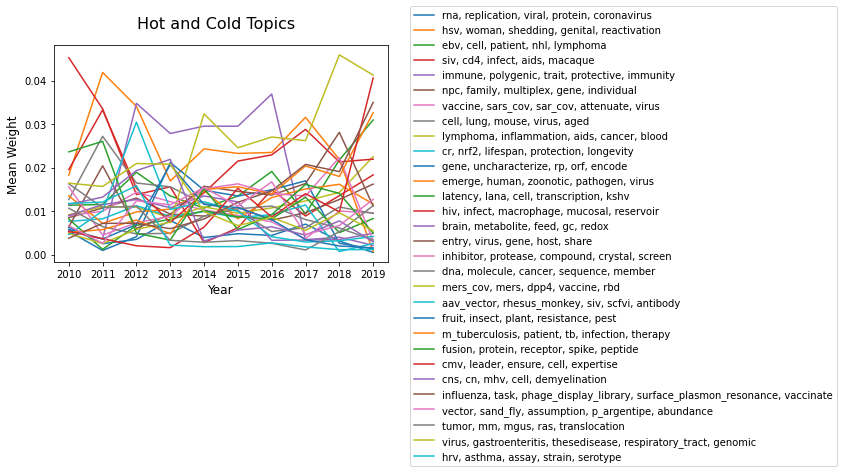

In [27]:
#Make Graphs
#leg = []
topic_results = {}
fig = plt.figure()
fig.suptitle('Hot and Cold Topics', fontsize=16)
ax = fig.add_subplot(111)

for i in range(1,num_topics+1):
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    topic_results[i] = linear_fit.coef_[0][0]
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,i])
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Weight', fontsize=12)
#ax.yaxis.set_label_coords(-0.14,0.5)
plt.legend(leg,bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.show()

In [28]:
class HandlerDashedLines(HandlerLineCollection):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = np.full_like(xdata, height / (numlines + 1))
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[0] is not None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines


In [31]:
# {column index, slope} - ex) 1: Topic 0 because Topic 0 is column 1 in the dataframe

#topic_results

In [29]:
def sort_dict(x):
    return sorted(x.items(), key=lambda l: l[1], reverse=True)

In [30]:
sort_slopes = sort_dict(topic_results)
top_slopes = [x[0] for x in sort_slopes[:5]]
bottom_slopes = [x[0] for x in sort_slopes[-5:]]

In [31]:
sort_slopes[:5]

[(19, 0.0047571527046299565),
 (26, 0.0028005810238088897),
 (24, 0.0027324255637766145),
 (22, 0.0025685513125046147),
 (3, 0.0013326797726567034)]

In [32]:
top_slopes

[19, 26, 24, 22, 3]

In [33]:
bottom_slopes

[25, 30, 29, 2, 4]

### plot hottest and coldest on same plot

In [34]:
# for plotting hot and cold on same graph

topnbot_slopes = top_slopes + bottom_slopes

In [35]:
topnbot_slopes

[19, 26, 24, 22, 3, 25, 30, 29, 2, 4]

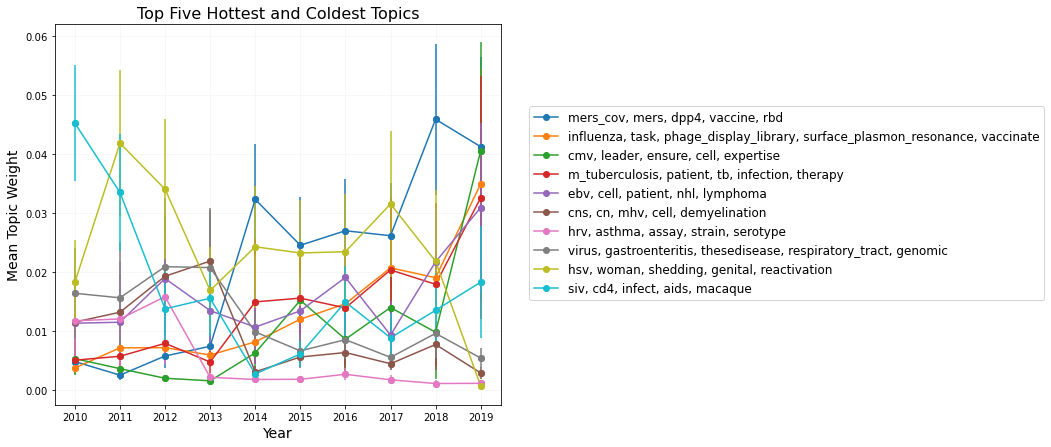

In [36]:
# Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

#color_list = ["#232d4b","#2c4f6b","#0e879c","#60999a","#d1e0bf","#d9e12b","#e6ce3a","#e6a01d","#e57200", "#ff0000"] #"#fdfdfd"]


line_return = []
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
line = [[(0, 0)]]
i = 0
for n in topnbot_slopes:
    zorder = 20
    color = color_list[i] 
    #if i < 5:
    #    zorder = 10 #10
    #    color = "#D3D3D3";
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color = color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color = color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
#plt.ylim(bottom = -0.001, top = 0.05)
plt.title('Top Five Hottest and Coldest Topics', fontsize=16)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])

# create the legend
#plt.legend(line_return, [leg[x-1] for x in topnbot_slopes], handler_map={type(line_return[0]): HandlerDashedLines()})
           #handlelength=2, bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')  #handleheight=2,

plt.legend([leg[x-1] for x in topnbot_slopes], bbox_to_anchor=(1.05, 0.6, 0.3, 0.2), loc='upper left', fontsize = 'large')
#plt.savefig("figures/updated_full_hot_cold_topics.png", dpi = 800, bbox_inches = "tight")
plt.show()


### Plot hottest and coldest topics on separate plots

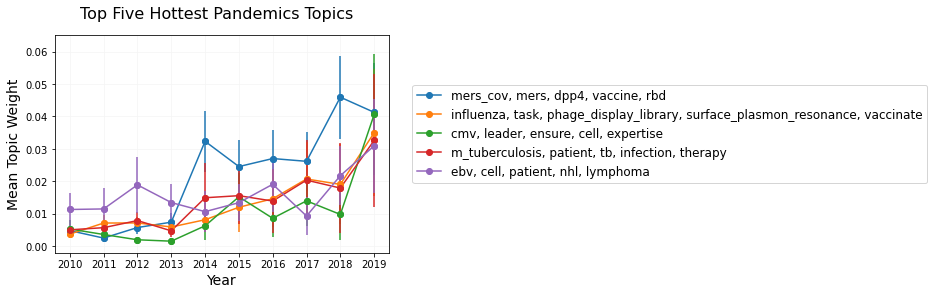

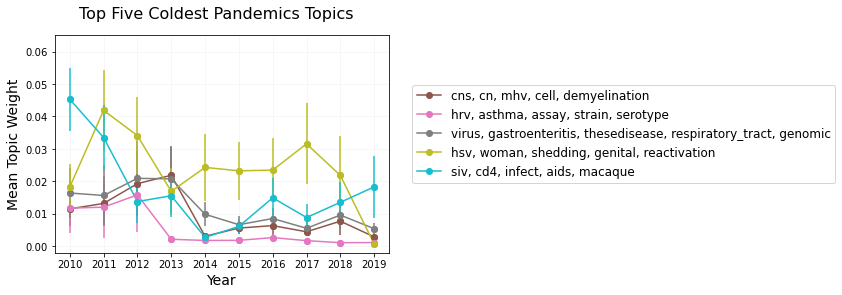

In [37]:
# Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

#color_list = ["#232d4b","#2c4f6b","#0e879c","#60999a","#d1e0bf","#d9e12b","#e6ce3a","#e6a01d","#e57200", "#ff0000"] #"#fdfdfd"]
#color_list = ["#D3D3D3","#2c4f6b","#C0C0C0","#A9A9A9","#808080","#D3D3D3","#2c4f6b","#D3D3D3","#D3D3D3", "#D3D3D3"] #"#fdfdfd"]


line_return = []
fig = plt.figure()
fig.suptitle('Top Five Hottest Pandemics Topics', fontsize=16)
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
line = [[(0, 0)]]
i = 0
for n in top_slopes:
    zorder = 10
    color = color_list[i] # "#D3D3D3"   
    if i == 0:
        zorder = 10 #20
        color = color_list[i];
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color = color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color = color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
plt.ylim(bottom = -0.002, top = 0.065)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])
# create the legend
#plt.legend(line_return, [leg[x-1] for x in top_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
#          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

plt.legend([leg[x-1] for x in top_slopes], bbox_to_anchor=(1.05, 0.6, 0.3, 0.2), loc='upper left', fontsize = 'large')
#plt.savefig("figures/coronavirus_hot_topics-new.png", dpi = 800, bbox_inches = "tight")
plt.show()


#Make Graphs
#leg = []

#bottom_slopes.reverse()  # so the plot legend has the coldest listed first

line_return = []
fig = plt.figure()
fig.suptitle('Top Five Coldest Pandemics Topics', fontsize=16)
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
i = 0
for n in bottom_slopes:
    zorder = 10
    color = color_list[i+5]  #"#D3D3D3"  
    if i == 4:
        zorder = 10 #20
        color = color_list[i+5]
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i+5])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color=color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color=color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i+5],color_list[i+5]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
plt.ylim(bottom = -0.002, top = 0.065)
#ax.yaxis.set_label_coords(-0.14,0.5)


# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])

# create the legend
#plt.legend(line_return, [leg[x-1] for x in bottom_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
#          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

plt.legend([leg[x-1] for x in bottom_slopes], bbox_to_anchor=(1.05, 0.6, 0.3, 0.2), loc='upper left', fontsize = 'large')
#plt.savefig("figures/coronavirus_cold_topics-new.png", dpi = 800, bbox_inches = "tight")
plt.show()


### create plot for specific topics

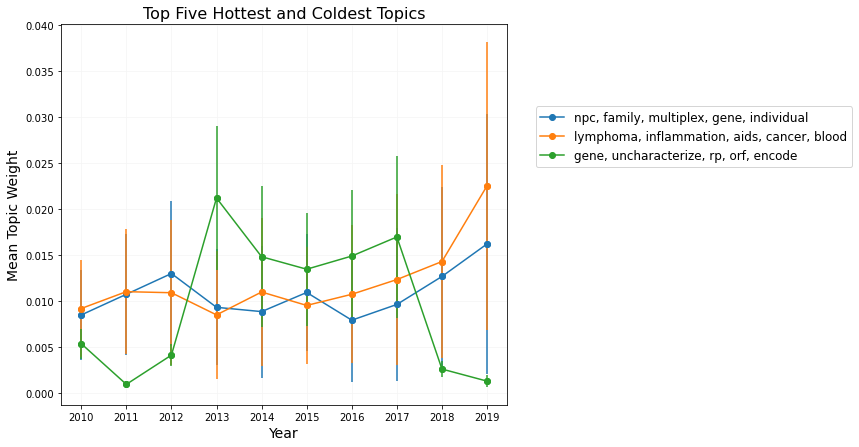

In [38]:
# Create plots for data stories in ET paper - topic numbers: 5, 8, 10 + 1 due to year being column 1

topic_idx = [6, 9, 11]

# Make Graphs
#leg = []
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

#color_list = ["#232d4b","#2c4f6b","#0e879c","#60999a","#d1e0bf","#d9e12b","#e6ce3a","#e6a01d","#e57200", "#ff0000"] #"#fdfdfd"]


line_return = []
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111)
plt.grid(True, color = "whitesmoke")
line = [[(0, 0)]]
i = 0
for n in topic_idx:
    zorder = 20
    color = color_list[i] 
    #if i < 5:
    #    zorder = 10 #10
    #    color = "#D3D3D3";
    linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,n].values.reshape(-1,1))
    #ax.plot(topic_wts_2010_2019["START_YEAR"], (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color = color, zorder = zorder)
    ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
            yerr = np.array(topic_wts_se_2010_2019.iloc[:,n]), fmt = "o", color = color, zorder = zorder)
    #line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    line_return.append(mcol.LineCollection(line, linestyles=['solid'], colors=[color]))
    i+=1
    #leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_wts_2010_2019["START_YEAR"].min(), topic_wts_2010_2019["START_YEAR"].max()+1, 1.0))
plt.xlabel('Year', fontsize=14)
plt.ylabel('Mean Topic Weight', fontsize=14)
#plt.ylim(bottom = -0.001, top = 0.05)
plt.title('Top Five Hottest and Coldest Topics', fontsize=16)
#ax.yaxis.set_label_coords(-0.14,0.5)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])
# create the legend
#plt.legend(line_return, [leg[x-1] for x in topic_idx], handler_map={type(line_return[0]): HandlerDashedLines()},
#          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left')

plt.legend([leg[x-1] for x in topic_idx], bbox_to_anchor=(1.05, 0.6, 0.3, 0.2), loc='upper left', fontsize = 'large')
#plt.savefig("figures/case-study.png", dpi = 800, bbox_inches = "tight")
plt.show()


## Plot for each topic in a grid

In [39]:
# get order of plots

sorted_slopes = [x[0] for x in sort_slopes]
sorted_slopes # indices from 1 to 30

# leg: indices 0-29

[19,
 26,
 24,
 22,
 3,
 16,
 9,
 12,
 6,
 17,
 14,
 13,
 27,
 11,
 18,
 1,
 7,
 10,
 21,
 28,
 5,
 15,
 23,
 20,
 8,
 25,
 30,
 29,
 2,
 4]

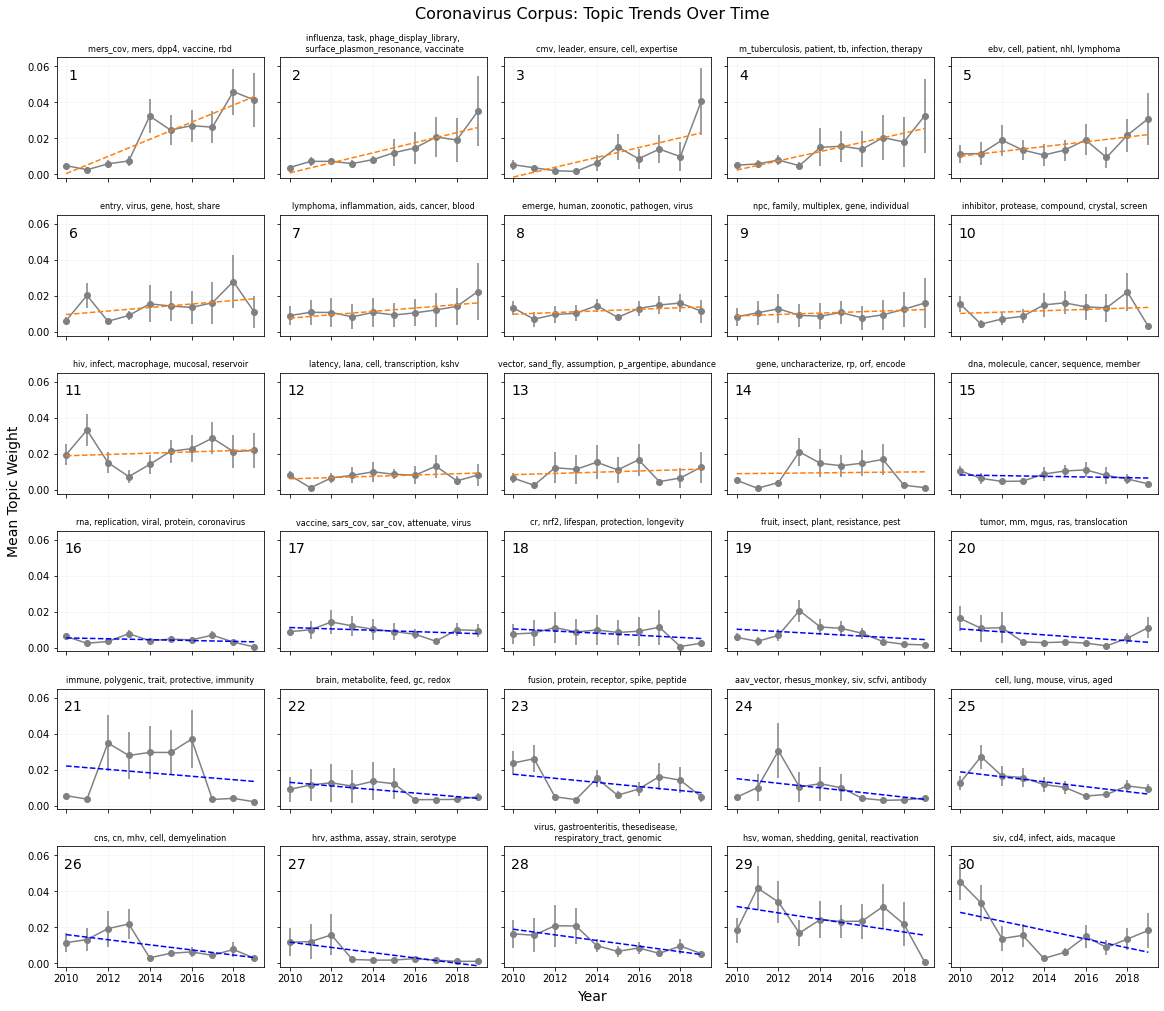

In [40]:
# set up grid
fig, ax = plt.subplots(6, 5, sharex = True, sharey = True, figsize=(16,14))
plt.ylim(bottom = -0.002, top = 0.065)

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_2010_2019.columns[col_idx]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019[col].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[i,j].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], 
            yerr = np.array(topic_wts_se_2010_2019[col]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")

    # put legend on two lines for topics 2, 28
    if count == 1:
        ax[i,j].set_title('influenza, task, phage_display_library, \n surface_plasmon_resonance, vaccinate', \
                          fontsize = 8)
    elif count == 27:
        ax[i,j].set_title('virus, gastroenteritis, thesedisease, \n respiratory_tract, genomic', fontsize = 8)
    else:
        ax[i,j].set_title(leg[col_idx-1], fontsize = 8)
    
    # add topic number to each plot
    ax[i,j].text(0.08, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    
fig.suptitle('Coronavirus Corpus: Topic Trends Over Time', fontsize = 16)
fig.text(0.5, -0.002, 'Year', ha='center', va='center', fontsize = 14)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.93)

plt.savefig("../figures/coronavirus/topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.show()

In [41]:
# get legend items for too long titles (topic 2)

leg[25]
leg[28]

'virus, gastroenteritis, thesedisease, respiratory_tract, genomic'

### Descriptive statistics on corpus

In [42]:
df["START_YEAR"].value_counts()

2008    107
2009     91
2010     89
2015     74
2011     71
2013     68
2016     63
2012     60
2014     59
2017     51
2018     45
2007     30
2019     30
2005     25
2004     18
2006     17
2001      9
1997      6
1985      5
1991      5
2002      5
1998      4
2003      4
1987      3
1981      3
1988      2
1980      2
1999      2
1975      2
1990      2
1977      1
1996      1
1979      1
1992      1
2000      1
Name: START_YEAR, dtype: int64

In [43]:
df["DEPARTMENT"].value_counts()

HHS     864
USDA     56
NSF      25
NASA      5
DOD       4
VA        3
Name: DEPARTMENT, dtype: int64

In [44]:
# filter data frame by year and repeat descriptive statistics.  Limit years to those for emerging topic analysis.

filt_df = df.copy()
filt_df["START_YEAR"] = filt_df["START_YEAR"].astype('int')

filt_df = filt_df[filt_df["START_YEAR"] > 2009]
filt_df = filt_df[filt_df["START_YEAR"] < 2020]

In [48]:
filt_df["START_YEAR"].value_counts().sort_index()

2010    89
2011    71
2012    60
2013    68
2014    59
2015    74
2016    63
2017    51
2018    45
2019    30
Name: START_YEAR, dtype: int64

In [46]:
filt_df["DEPARTMENT"].value_counts()

HHS     544
USDA     34
NSF      21
DOD       4
NASA      4
VA        3
Name: DEPARTMENT, dtype: int64

In [47]:
filt_df.pivot_table(index=['DEPARTMENT','START_YEAR'], aggfunc='size')

DEPARTMENT  START_YEAR
DOD         2015           1
            2018           1
            2019           2
HHS         2010          80
            2011          69
            2012          55
            2013          55
            2014          51
            2015          63
            2016          52
            2017          49
            2018          42
            2019          28
NASA        2010           1
            2015           2
            2016           1
NSF         2010           2
            2012           3
            2013           3
            2014           2
            2015           2
            2016           6
            2017           1
            2018           2
USDA        2010           5
            2011           1
            2012           2
            2013           9
            2014           6
            2015           6
            2016           4
            2017           1
VA          2010           1
            2011    